*****
# Intel® Scalable Dataframe Compiler
*****

### A compiler-based framework for big data in Python  
Intel® Scalable Dataframe Compiler (Intel® SDC) scales analytics/ML codes in Python to bare-metal cluster/cloud performance automatically. It compiles a subset of Python (Pandas/Numpy) to efficient parallel binaries with MPI, requiring only minimal code changes
*****

## Installing

*Installing Binary Packages (conda)*  
`conda install -c intel -c intel/label/test sdc`

SDC advances numba in two dimensions:

1. Support for pandas dataframes and operations  
2. Scaling out to a cluster using MPI

## Machine Learning Problem Statement

The notebook below has been made to demonstrate sdc and daal4py in a data science context. It applies a Cycling Dataset from a social fitness network, and attempts to create a linear regression model from the 5 features collected for telemetry to predict the user's Power output in the absence of a power meter  

In [1]:
import hpat # Original module name
import numba

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Load and Prepare the data

In [4]:
@hpat.jit
def read_from_parquet():
    filename = 'cycling_dataset.pq'
    df = pd.read_parquet(filename)
    return df

In [5]:
df = read_from_parquet()
print(df.shape)

(1000000, 9)


In [4]:
df.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,185.800003,51,3.46,81,30.313309,-97.732711,45,3.459,2016-10-20 22:01:26
1,185.800003,68,7.17,82,30.313277,-97.732715,0,3.710,2016-10-20 22:01:27
2,186.399994,38,11.04,82,30.313243,-97.732717,42,3.874,2016-10-20 22:01:28
3,186.800003,38,15.18,83,30.313212,-97.732720,5,4.135,2016-10-20 22:01:29
4,186.600006,38,19.43,83,30.313172,-97.732723,1,4.250,2016-10-20 22:01:30


## Performance of dataset loading from parquet

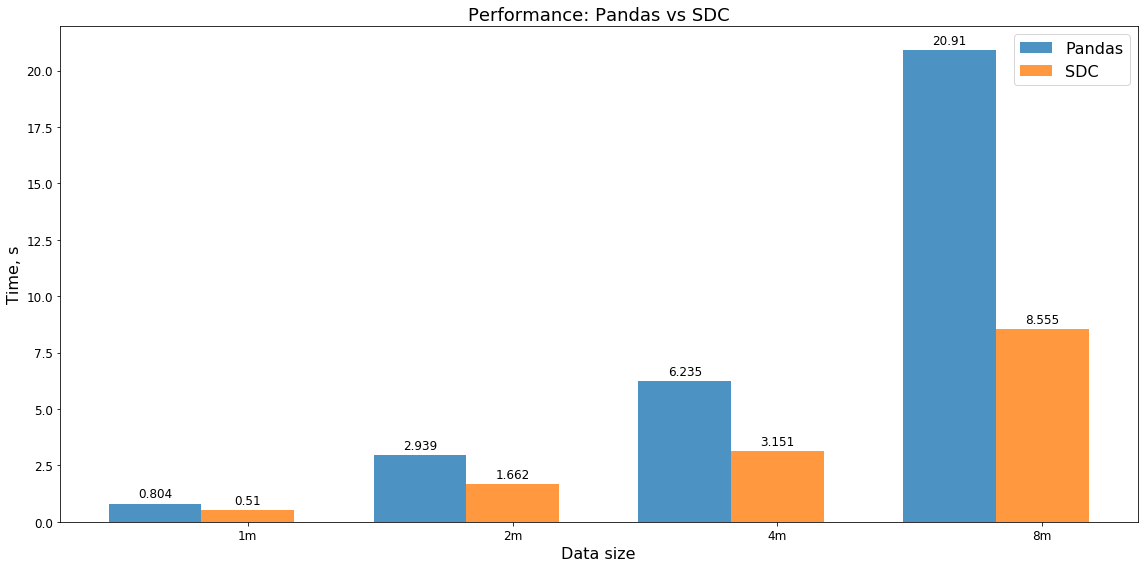

In [2]:
from performance import Plotter

pl = Plotter()
pl.plot_performance()

In [2]:
@hpat.jit
def read_from_csv():
    filename = 'cycling_dataset_2.csv'
    # Currrently we need to provide column names and their types
    names = ['altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed', 'time']
    dtypes = {
        'altitude': np.float64,
        'cadence': np.float64,
        'distance': np.float64,
        'hr': np.float64,
        'latitude': np.float64,
        'longitude': np.float64,
        'power': np.float64,
        'speed': np.float64,
        'time': str
    }
    df = pd.read_csv(filename, names=names, dtype=dtypes, skiprows=1)
    return df

In [3]:
df = read_from_csv()
df.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,1.0,1.0,185.800003,68.0,7.170000,82.0,30.313277,-97.732715,0
1,2.0,2.0,186.399994,38.0,11.040000,82.0,30.313243,-97.732717,42
2,3.0,3.0,186.800003,38.0,15.180000,83.0,30.313212,-97.732720,5
3,4.0,4.0,186.600006,38.0,19.430000,83.0,30.313172,-97.732723,1
4,5.0,5.0,186.600006,0.0,23.860001,84.0,30.313130,-97.732724,0


**Try it with MPI: run on 4 processes**  
`%save -f runme.py ??
!mpirun -n 4 python ./runme.py`

## Performance of dataset loading from csv: MPI parallelization

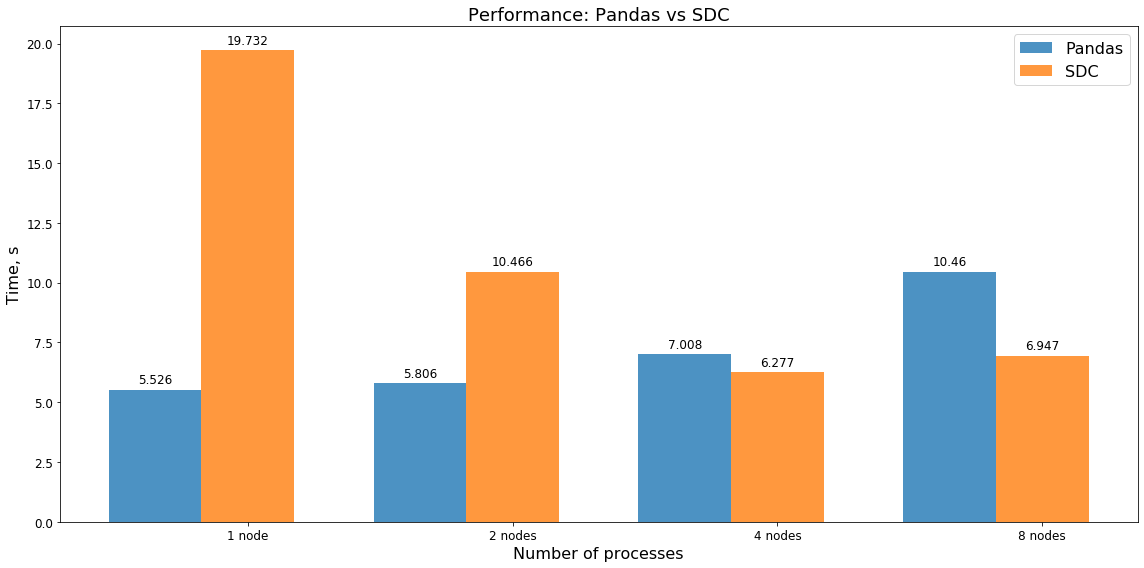

In [14]:
from performance import Plotter

pl = Plotter('read_csv')
pl.plot_performance()

## Performance of dataframe.describe()

In [28]:
@hpat.jit
def data_describe(df):
    # Drop not numerical values from dataframe
    df = df[['altitude', 'cadence', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed']]
    result = df.describe()
    return result

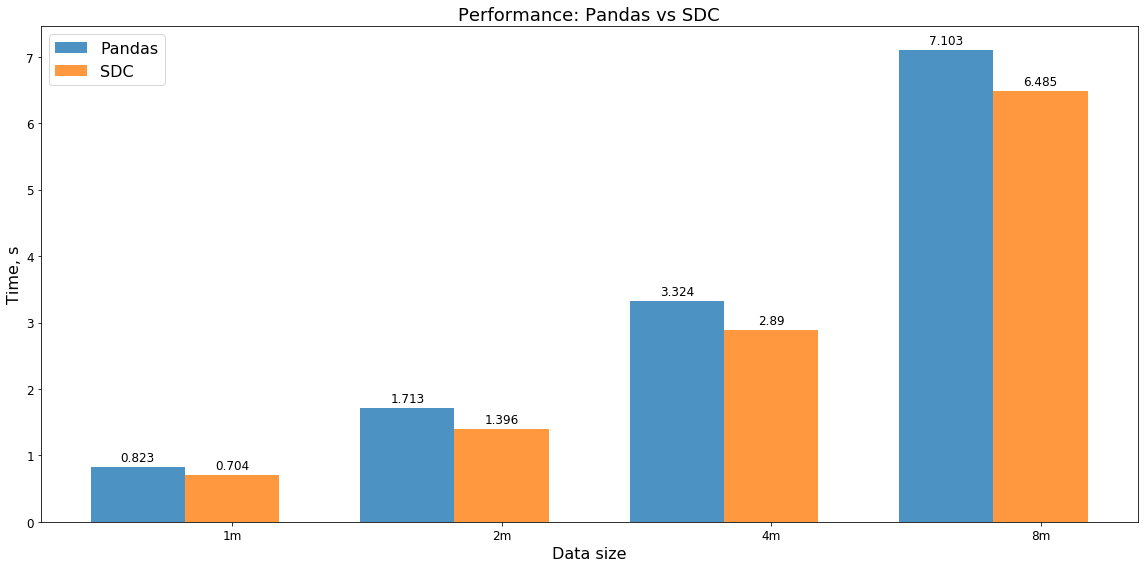

In [3]:
from performance import Plotter

pl = Plotter('describe')
pl.plot_performance()

## Performance of series.value_counts()

In [5]:
@hpat.jit
def data_value_counts(column):
    result = column.value_counts()
    return result

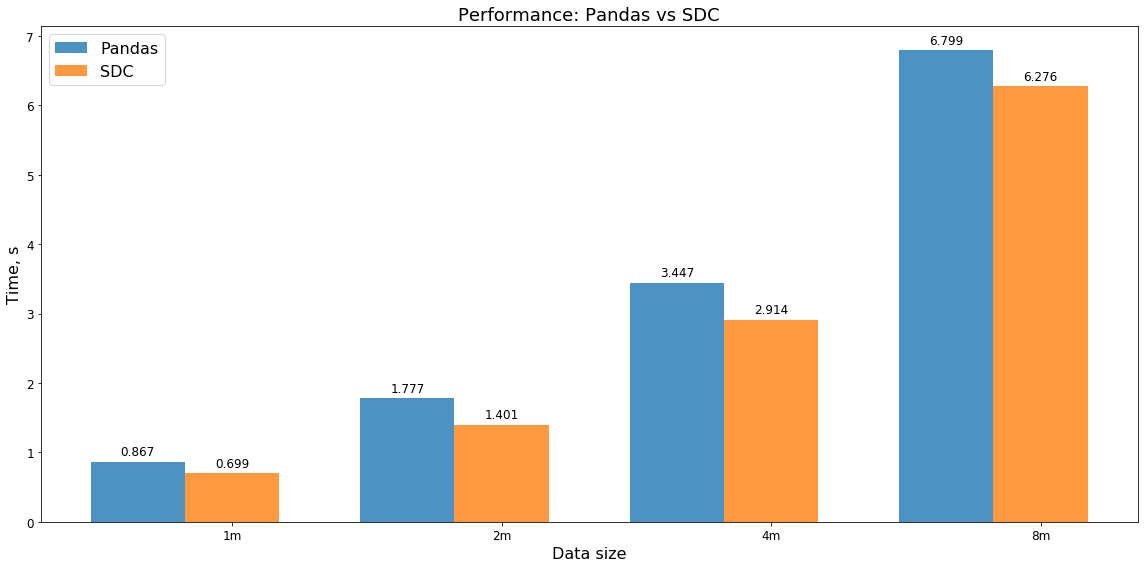

In [2]:
from performance import Plotter

pl = Plotter('v_counts')
pl.plot_performance()

In [31]:
def merge_dfs(df):
    start = time.time()
    df1 = df[['altitude', 'cadence', 'distance', 'hr', 'time']]
    df2 = df[['latitude', 'longitude', 'power', 'speed', 'time']]
    df3 = df1.merge(df2, on='time')
    end = time.time() - start
    return len(df3), end

In [32]:
sdc_merge = hpat.jit(merge_dfs)
_, t = merge_dfs(df)
_, sdc_t = sdc_merge(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

TIME python:  160.94312167167664
TIME SDC:  284.91856871040363


In [20]:
def groupby_operation(df):
    start = time.time()
    grp = df.groupby('power')
    mean = grp['speed'].mean()
    end = time.time() - start
    return mean, end


In [21]:
sdc_groupby = hpat.jit(groupby_operation)
_, t = groupby_operation(df)
_, sdc_t = sdc_groupby(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

TIME python:  0.05549812316894531
TIME SDC:  0.10742287183529697


## Split the data

In [22]:
def data_split(df):
    start = time.time()
    # Remove entries where power==0
    train = df[df.power!=0]
    # Reduce the dataset, create X.  We drop the target, and other non-essential features.
    reduced_dataset = train.drop(['time','power','latitude','longitude'], axis=1)
    # Get the target, create Y as an 2d array of float64
    target = train.power.values.reshape(len(train), 1).astype(np.float64)
    end = time.time() - start
    
    return train, target, end

In [26]:
sdc_split = hpat.jit(data_split)
train, target, t = data_split(df)
sdc_train, sdc_target, sdc_t = sdc_split(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

LoweringError: Failed in nopython mode pipeline (step: nopython mode backend)
[1m[1mCannot cast dataframe((array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), StringArrayType()), none, ('altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed', 'time'), False) to dataframe((array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(int64, 1d, C), array(float64, 1d, C), StringArrayType()), none, ('altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed', 'time'), True): %".4503" = load {{{i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i64, i64, i32*, i8*, i8*, i8*}}, i8*, [9 x {i8*, i64, i32, i32, i64, i8*, i8*}], [10 x i8], i8*}, {{{i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, double*, [1 x i64], [1 x i64]}, {i64, i64, i32*, i8*, i8*, i8*}}, i8*, [9 x {i8*, i64, i32, i32, i64, i8*, i8*}], [10 x i8], i8*}* %"$0.24.2147"
[1m
File "<string>", line 2:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1m[1] During: lowering "$train.2294 = $0.24.2147" at <string> (2)[0m


In [25]:
train, target, t = data_split(df)

## Train the model

After the data was previously processed it can be passed to the ML model input.  
The following code trains a model to predict the power output.

In [33]:
import daal4py as d4p

ModuleNotFoundError: No module named 'daal4py'

In [ ]:
# Create a linear regression algorithm object
d4p_lm = d4p.linear_regression_training(interceptFlag=True)
# Train the model
lm_trained = d4p_lm.compute(reduced_dataset.values, target)

In [ ]:
print("Model has this number of features: ", lm_trained.model.NumberOfFeatures)

## Predict

In [ ]:
def predict(model):
    # create our prediction algorithm object
    lm_predictor = d4p.linear_regression_prediction()
    # Now run prediction. The arguments use the independent data and the trained model from above as the parameters.
    result = lm_predictor.compute(subset.values, model)
    
    return result

In [ ]:
pred_result = predict(train_result.model)

In [ ]:
test_set = pd.read_parquet('cycling_test_dataset.pq')
test_set = test_set[test_set.power!=0]
plt.plot(pred_result.prediction[0:300])
plt.plot(test_set.power.values[0:300])
plt.show()